In [ ]:
from biosppy.signals import ecg
import scipy.signal as ss

# Load data

In [2]:
# Load data
def load_data(train_path, test_path):
    train = pd.read_csv(train_path, index_col="id")
    test = pd.read_csv(test_path, index_col="id")
    return train, test

# Handle NaNs and normalize
def preprocess_signals(data):
    """
    Normalize signal data while handling potential division by zero.
    """
    signal_cols = [col for col in data.columns if col.startswith('x')]

    def safe_normalize(x):
        std = x.std(skipna=True)
        return (x - x.mean(skipna=True)) / std if std > 0 else x  # Skip normalization if std=0

    # Normalize while preserving NaNs
    data[signal_cols] = data[signal_cols].apply(safe_normalize, axis=1)

    # Replace NaNs with 0 after normalization
    data[signal_cols] = data[signal_cols].fillna(0)

    return data

# Load train and test data
train_path = "data/train_inversion_nkecg.csv"
test_path = "data/test_inversion_nkecg.csv"
train, test = load_data(train_path, test_path)

# Preprocess signals
train = preprocess_signals(train)
test = preprocess_signals(test)

# Verify
print(f"Train shape: {train.shape}, Test shape: {test.shape}")


Train shape: (5117, 17808), Test shape: (3411, 17807)


# FEATURE EXTRACTION + TRAINING

In [1]:
from scipy.stats import kurtosis
from biosppy.signals.ecg import ecg
from neurokit2 import ecg_delineate
#import entropy as ent
import numpy as np
import traceback
from pyentrp import entropy as pyent
from scipy import signal

def extract_features(signal, sampling_rate=300):
    features = {}
    try:
        # Patch scipy.signal.hamming only if it doesn't exist
        if not hasattr(ss, "hamming"):
            ss.hamming = np.hamming

        # Patch scipy.signal.boxcar if missing
        if not hasattr(ss, "boxcar"):
            def boxcar(M):
                return np.ones(M)
            ss.boxcar = boxcar


            # Ensure the signal is valid
        if len(signal) == 0 or np.all(np.isnan(signal)):
            raise ValueError("Signal is empty or all NaN.")

        # Process the ECG signal
        try:
            _, filtered, rpeaks, _, _, _, heart_rate = ecg(signal, sampling_rate=sampling_rate, show=False)
        except Exception as ecg_error:
            print(f"ECG processing failed: {ecg_error}")
            raise ValueError("ECG processing failed")

       # Validate R-peaks
        if len(rpeaks) == 0:
            raise ValueError("No R-peaks detected in the signal.")

        # RR Intervals and HRV (Heart Rate Variability)
        try:
            r_times = rpeaks / sampling_rate
            rr_intervals = np.diff(r_times)
            if len(rr_intervals) > 1:
                rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
                sdnn = np.std(rr_intervals)
                cvsd = rmssd / sdnn if sdnn > 0 else 0
                pnn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05) / len(rr_intervals)
            else:
                rmssd = sdnn = cvsd = pnn50 = 0

            features.update({
                "mean_rr": np.nanmean(rr_intervals) if len(rr_intervals) > 0 else 0,
                "std_rr": np.nanstd(rr_intervals) if len(rr_intervals) > 0 else 0,
                "min_rr": np.nanmin(rr_intervals) if len(rr_intervals) > 0 else 0,
                "max_rr": np.nanmax(rr_intervals) if len(rr_intervals) > 0 else 0,
                "rmssd": rmssd,
                "sdnn": sdnn,
                "cvsd": cvsd,
                "pnn50": pnn50,
            })
        except Exception as hrv_error:
            print(f"HRV feature extraction failed: {hrv_error}")
            features.update({
                "mean_rr": 0, "std_rr": 0, "min_rr": 0, "max_rr": 0,
                "rmssd": 0, "sdnn": 0, "cvsd": 0, "pnn50": 0
            })

        # Morphological Features
        try:
            if len(filtered) > 0 and len(rpeaks) > 0:
                delineation = ecg_delineate(filtered, rpeaks, sampling_rate, method="cwt")[1]
                q_peaks = delineation.get("ECG_Q_Peaks", [])
                t_peaks = delineation.get("ECG_T_Peaks", [])

                # Validate and align Q and T peaks
                q_peaks = [int(p) for p in q_peaks if not np.isnan(p) and 0 <= int(p) < len(filtered)]
                t_peaks = [int(p) for p in t_peaks if not np.isnan(p) and 0 <= int(p) < len(filtered)]

                if len(q_peaks) > 0 and len(t_peaks) > 0:
                    qt_interval = np.nanmean(np.array(t_peaks) - np.array(q_peaks)) / sampling_rate
                else:
                    qt_interval = 0

                features.update({
                    "mean_r_amp": np.nanmean(filtered[rpeaks]) if len(rpeaks) > 0 else 0,
                    "std_r_amp": np.nanstd(filtered[rpeaks]) if len(rpeaks) > 0 else 0,
                    "mean_q_amp": np.nanmean(filtered[q_peaks]) if len(q_peaks) > 0 else 0,
                    "std_q_amp": np.nanstd(filtered[q_peaks]) if len(q_peaks) > 0 else 0,
                    "mean_t_amp": np.nanmean(filtered[t_peaks]) if len(t_peaks) > 0 else 0,
                    "std_t_amp": np.nanstd(filtered[t_peaks]) if len(t_peaks) > 0 else 0,
                    "qt_interval": qt_interval,
                })
        except Exception as morph_error:
            print(f"Morphological feature extraction failed: {morph_error}")
            features.update({
                "mean_r_amp": 0, "std_r_amp": 0,
                "mean_q_amp": 0, "std_q_amp": 0,
                "mean_t_amp": 0, "std_t_amp": 0,
                "qt_interval": 0,
            })

        # Frequency Domain Features
        try:
            freq = np.fft.rfftfreq(len(signal), 1 / sampling_rate)
            spectrum = np.abs(np.fft.rfft(signal))
            if len(spectrum) > 0:
                low_freq_band = (freq >= 0.04) & (freq <= 0.15)
                high_freq_band = (freq >= 0.15) & (freq <= 0.4)
                lf_power = np.sum(spectrum[low_freq_band])
                hf_power = np.sum(spectrum[high_freq_band])
                features.update({
                    "fft_peak_freq": freq[np.argmax(spectrum)],
                    "fft_mean": np.nanmean(spectrum),
                    "fft_std": np.nanstd(spectrum),
                    "low_freq_power": lf_power,
                    "high_freq_power": hf_power,
                    "lf_hf_ratio": lf_power / (hf_power + 1e-10),
                })
            else:
                features.update({
                    "fft_peak_freq": 0, "fft_mean": 0, "fft_std": 0,
                    "low_freq_power": 0, "high_freq_power": 0, "lf_hf_ratio": 0
                })
        except Exception as freq_error:
            print(f"Frequency domain feature extraction failed: {freq_error}")
            features.update({
                "fft_peak_freq": 0, "fft_mean": 0, "fft_std": 0,
                "low_freq_power": 0, "high_freq_power": 0, "lf_hf_ratio": 0
            })

        # Nonlinear Features
        try:
            features.update({
                "sample_entropy": pyent.sample_entropy(signal, 2, 0.2 * np.nanstd(signal))[0] if len(signal) > 0 else 0,
                "poincare_sd1": np.nanstd(rr_intervals) / np.sqrt(2) if len(rr_intervals) > 0 else 0,
                "poincare_sd2": np.sqrt(2) * np.nanstd(rr_intervals) if len(rr_intervals) > 0 else 0,
            })
        except Exception as nonlinear_error:
            print(f"Nonlinear feature extraction failed: {nonlinear_error}")
            features.update({
                "sample_entropy": 0, "poincare_sd1": 0, "poincare_sd2": 0
            })

        # Morphology Statistical Features
        try:
            features.update({
                "signal_ptp_amplitude": np.ptp(signal),
                "kurtosis": kurtosis(signal),
            })
        except Exception as stats_error:
            print(f"Statistical feature extraction failed: {stats_error}")
            features.update({
                "signal_ptp_amplitude": 0, "kurtosis": 0
            })

        # Artifact Detection
        try:
            artifact_ratio = np.sum(np.abs(signal) > 3 * np.nanstd(signal)) / max(len(signal), 1)
            features.update({"artifact_ratio": artifact_ratio})
        except Exception as artifact_error:
            print(f"Artifact detection failed: {artifact_error}")
            features.update({"artifact_ratio": 0})

    except Exception as e:
        print(f"Critical error processing signal: {e}")
        traceback.print_exc()
        #features = {k: 0 for k in [
        #    "mean_rr", "std_rr", "min_rr", "max_rr", "rmssd", "sdnn", "cvsd", "pnn50",
        #    "mean_r_amp", "std_r_amp", "mean_q_amp", "std_q_amp", "mean_t_amp", "std_t_amp",
        #    "qt_interval", "fft_peak_freq", "fft_mean", "fft_std", "low_freq_power",
        #    "high_freq_power", "lf_hf_ratio", "sample_entropy", "poincare_sd1", "poincare_sd2",
        #    "signal_ptp_amplitude", "kurtosis", "artifact_ratio"
        #]}

        raise e

    return features

In [28]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

def process_row(row, signal_cols, sampling_rate):
    """
    Process a single row to extract features with detailed error logging.
    """
    try:
        signal = row[signal_cols].to_numpy(dtype="float32")
        features = extract_features(signal, sampling_rate=sampling_rate)
        features["id"] = row.name
        if "y" in row:
            features["label"] = row["y"]
        return features
    except Exception as e:
        print(f"Error processing row with id={row.name}: {e}")
        return {"id": row.name, "label": row.get("y", -1)}  # Add fallback with minimal info


def extract_features_from_df_parallel(data, sampling_rate=300, n_jobs=-1):
    """
    Extract features from a DataFrame in parallel with detailed logging.
    """
    signal_cols = [col for col in data.columns if col.startswith('x')]

    # Use Parallel for efficient processing
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(row, signal_cols, sampling_rate)
        for _, row in tqdm(data.iterrows(), total=len(data), desc="Extracting Features in Parallel")
    )

    return pd.DataFrame(results)


# Extract features for train and test
train_features = extract_features_from_df_parallel(train, sampling_rate=300, n_jobs=-1)
test_features = extract_features_from_df_parallel(test, sampling_rate=300, n_jobs=-1)







Extracting Features in Parallel:   0%|          | 0/5117 [00:00<?, ?it/s]




Extracting Features in Parallel:   0%|          | 1/5117 [00:00<42:17,  2.02it/s]




Extracting Features in Parallel:   0%|          | 22/5117 [00:03<12:20,  6.88it/s]




Extracting Features in Parallel:   1%|          | 33/5117 [00:04<10:55,  7.76it/s]




Extracting Features in Parallel:   1%|          | 44/5117 [00:05<10:13,  8.27it/s]




Extracting Features in Parallel:   1%|          | 55/5117 [00:06<09:31,  8.86it/s]




Extracting Features in Parallel:   1%|▏         | 66/5117 [00:08<10:00,  8.41it/s]




Extracting Features in Parallel:   2%|▏         | 77/5117 [00:09<10:54,  7.70it/s]




Extracting Features in Parallel:   2%|▏         | 88/5117 [00:11<10:31,  7.96it/s]




Extracting Features in Parallel:   2%|▏         | 99/5117 [00:12<10:01,  8.34it/s]




Extracting Features in Parallel:   2%|▏         | 110/5117 [00:13<10:33,  7.90it/s]




Extracting Features in Parallel:   2%|▏        

       mean_rr    std_rr    min_rr    max_rr     rmssd      sdnn      cvsd  \
0     0.815909  0.064492  0.326667  0.853333  0.063715  0.064492  0.987962   
1     0.788381  0.043508  0.693333  0.863333  0.026476  0.043508  0.608534   
2     0.900690  0.035183  0.836667  0.990000  0.026622  0.035183  0.756673   
3     0.411111  0.072850  0.336667  0.680000  0.099594  0.072850  1.367108   
4     0.598768  0.071134  0.280000  0.740000  0.085240  0.071134  1.198304   
...        ...       ...       ...       ...       ...       ...       ...   
5112  0.723478  0.205282  0.260000  1.036667  0.262399  0.205282  1.278237   
5113  0.864624  0.014159  0.840000  0.916667  0.010954  0.014159  0.773658   
5114  0.788857  0.093981  0.670000  0.993333  0.032585  0.093981  0.346718   
5115  0.848333  0.027525  0.793333  0.896667  0.034485  0.027525  1.252867   
5116  0.591212  0.036000  0.533333  0.680000  0.015351  0.036000  0.426421   

         pnn50  mean_r_amp  std_r_amp  ...  high_freq_power  lf

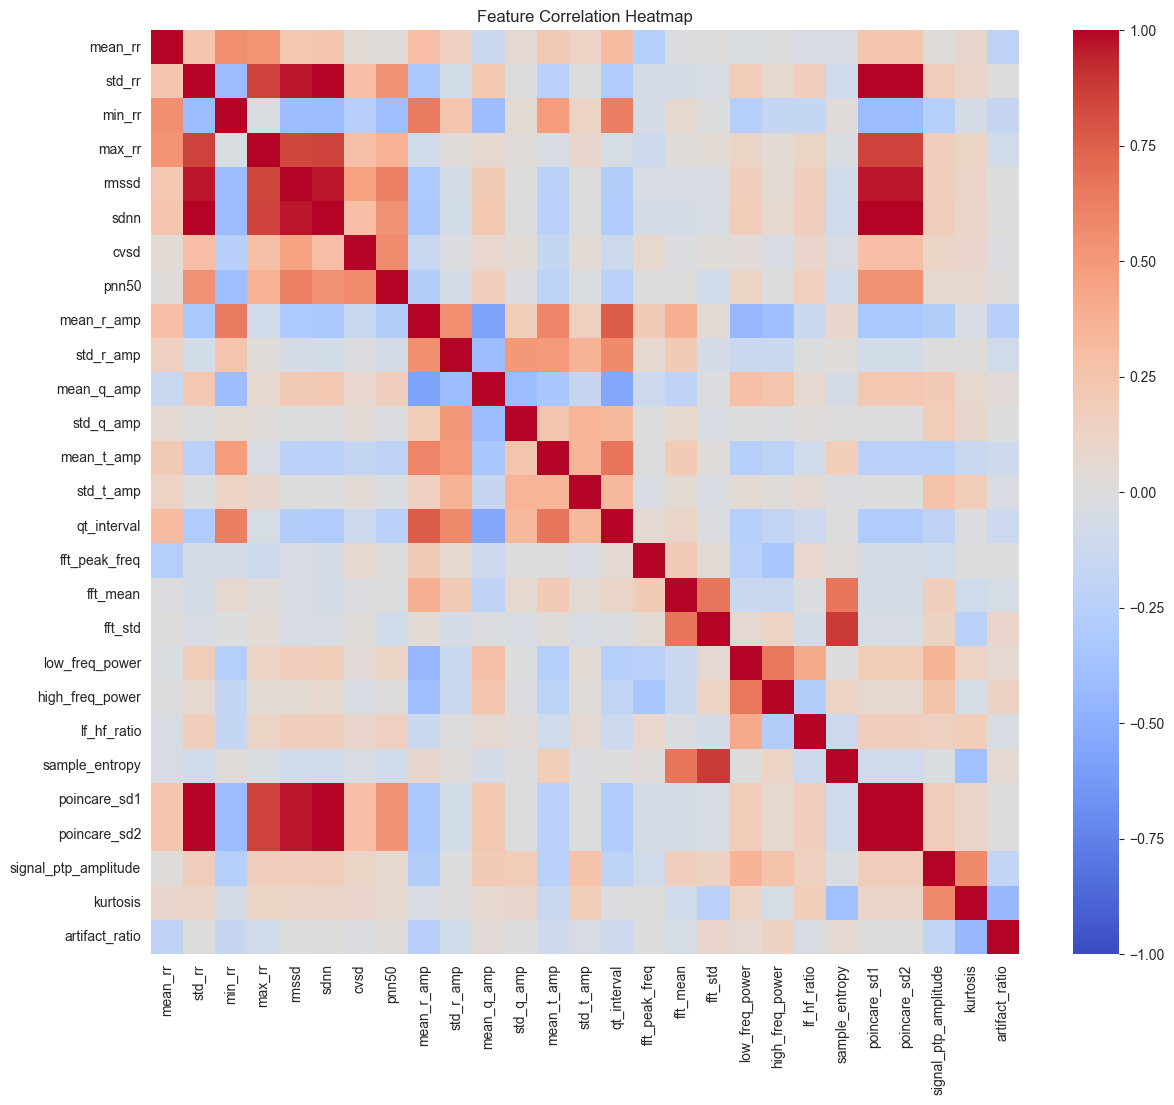

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = train_features.drop(columns=["id", "label"], errors="ignore").corr()
print(train_features)

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()


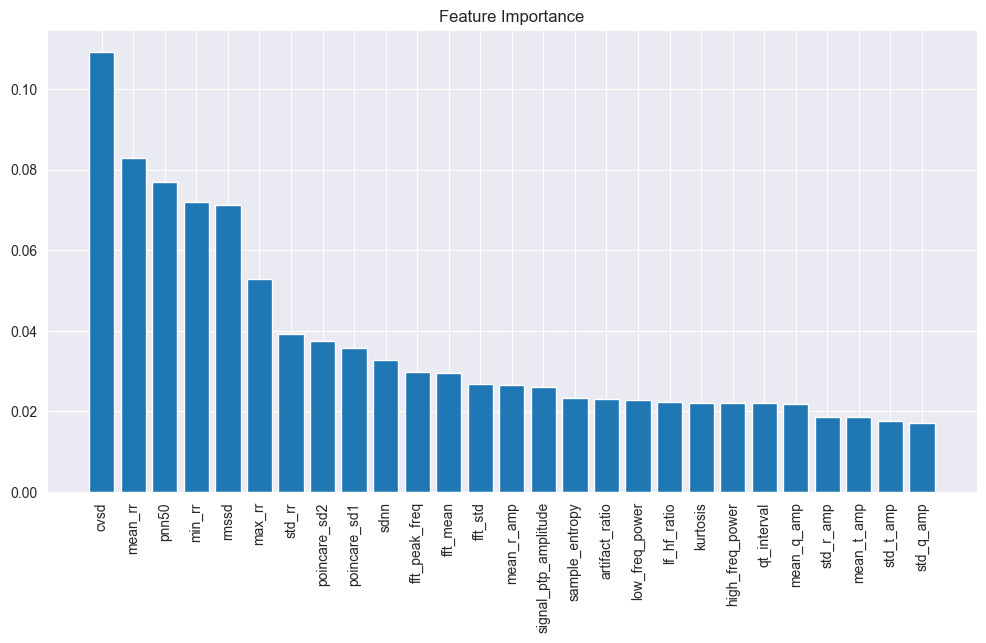

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Train a simple Random Forest
X = train_features.drop(columns=["id", "label"])
y = train_features["label"]
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Plot feature importances
importances = rf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.show()


In [31]:
print(f"Train features shape: {train_features.shape}, Test features shape: {test_features.shape}")

Train features shape: (5117, 29), Test features shape: (3411, 28)


# PIPELINE

In [51]:
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# Prepare data for modeling
X = train_features.drop(columns=["id", "label"])  # Drop 'id' and 'label' to get only features
y = train_features["label"]  # Target variable

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define SVM pipeline with best parameters
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=3.9495, probability=True, random_state=42)  # Updated SVM with optimal C
)

# Define Gradient Boosting pipeline with best parameters
gb_pipeline = make_pipeline(
    StandardScaler(),
    HistGradientBoostingClassifier(
        learning_rate=0.013,  # Updated learning rate
        max_iter=212,         # Updated max iterations
        random_state=42
    )
)

# Define XGBoost pipeline with best parameters
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        learning_rate=0.2,   # Updated learning rate
        max_depth=7,         # Updated max depth
        eval_metric="mlogloss",  # Disable warning for evaluation metric
        random_state=42
    )
)

# Create the ensemble
ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_pipeline),
        ('gb', gb_pipeline),
        ('xgb', xgb_pipeline)
    ],
    voting='soft'  # Use soft voting to average probabilities
)

# Cross-validation
print("Performing cross-validation...")
cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring="f1_micro")
print(f"CV F1 Scores: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Train and evaluate
print("Fitting ensemble on training data...")
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_val)
f1 = f1_score(y_val, y_pred, average="micro")
print(f"Validation F1 Score: {f1:.4f}")

# Adjust test_features to drop the extra 'y' column
test_features_cleaned = test_features.drop(columns=["y"], errors="ignore")  # Drop 'y' if it exists

# Predict on test set
print("Predicting on test set...")
X_test = test_features_cleaned.drop(columns=["id"])  # Features only
test_predictions = test_features_cleaned[["id"]].copy()  # Preserve 'id' column for submission
test_predictions["y"] = ensemble.predict(X_test)  # Add predictions to the copied DataFrame

# Save submission
submission = test_predictions[["id", "y"]]
submission.to_csv("out/submission25_ensemble_SVM_GB_XGB_Voting_all_features_GRIDSEARCH.csv", index=False)
print("Submission file created!")


Performing cross-validation...
CV F1 Scores: 0.8058 ± 0.0080
Fitting ensemble on training data...
Validation F1 Score: 0.8213
Predicting on test set...
Submission file created!


SANS GRIDSEARCH HYPERPARAM: (en utilisant les meilleurs paramètres trouvés dans le notebook précédent)
Performing cross-validation...
CV F1 Scores: 0.8116 ± 0.0054
Fitting ensemble on training data...
Validation F1 Score: 0.8174
Predicting on test set...
Submission file created!

AVEC GRIDSEARCH HYPERPARAM:
Performing cross-validation...
CV F1 Scores: 0.8058 ± 0.0080
Fitting ensemble on training data...
Validation F1 Score: 0.8213
Predicting on test set...
Submission file created!

--> BIZARRE MEILLEUR F1 SCORE AVEC GRIDSEARCH MAIS MOINS BONNE PERFORMANCE EN CROSS-VALIDATION --> OVERFITTING ?

# Hyperparameter Tuning with Grid Search

In [50]:
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np

# Prepare data for modeling
X = train_features.drop(columns=["id", "label"])  # Drop 'id' and 'label' to get only features
y = train_features["label"]  # Target variable

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual pipelines
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(probability=True, random_state=42)
)

gb_pipeline = make_pipeline(
    StandardScaler(),
    HistGradientBoostingClassifier(random_state=42)
)

xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBClassifier(eval_metric="mlogloss", random_state=42)
)

# Further refined parameter grid
param_grid = {
    'svm__svc__C': [3.9495],  # 3.9495
    'gb__histgradientboostingclassifier__learning_rate': [0.013],  # 0.013
    'gb__histgradientboostingclassifier__max_iter': [212],  # BEST
    'xgb__xgbclassifier__max_depth': [7],  # BEST
    'xgb__xgbclassifier__learning_rate': [0.2],  # BEST
}

# Create the ensemble
ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_pipeline),
        ('gb', gb_pipeline),
        ('xgb', xgb_pipeline),
    ],
    voting='soft'  # Use soft voting to average probabilities
)

# Perform Grid Search with verbose output
grid_search = GridSearchCV(
    estimator=ensemble,
    param_grid=param_grid,
    scoring="f1_micro",
    cv=3,
    verbose=3,  # Verbose for detailed output
    n_jobs=-1  # Use all available CPUs
)

# Fit grid search
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

# Print best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

# Evaluate on validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
f1 = f1_score(y_val, y_pred, average="micro")
print(f"Validation F1 Score with Best Model: {f1:.4f}")


Starting Grid Search...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'gb__histgradientboostingclassifier__learning_rate': 0.013, 'gb__histgradientboostingclassifier__max_iter': 212, 'svm__svc__C': 3.9495, 'xgb__xgbclassifier__learning_rate': 0.2, 'xgb__xgbclassifier__max_depth': 7}
Best CV Score: 0.8129
Validation F1 Score with Best Model: 0.8213


Starting Grid Search...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'gb__histgradientboostingclassifier__learning_rate': 0.013, 'gb__histgradientboostingclassifier__max_iter': 212, 'svm__svc__C': 3.9495, 'xgb__xgbclassifier__learning_rate': 0.2, 'xgb__xgbclassifier__max_depth': 7}
Best CV Score: 0.8129
Validation F1 Score with Best Model: 0.8213